In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

#input is the edge table from each group
#This segment will be used in all code chunks. 
#Make sure to run this chunk and the chunk with functions (the cell below this) are run BEFORE any of the other cells


list_of_files = [['pos-org-adj-edge.csv','pos-org-MASP-edge.csv'],
                 ['pos-org-adj-edge.csv','pos-org-NGP24h-edge.csv'],
                 ['pos-org-adj-edge.csv', 'pos-org-MASP-NGP24h-edge.csv']
                ]

#make a list of tissues in the same order as the files above for naming purposes
list_of_comparisons = ['adj_MASP', 'adj_NGP24h','adj_MASP_NGP24h']



#some functions that we will need later

def sort_dictionary_by_value(dictionary):
    # Sort the dictionary items by their values in descending order
    sorted_items = sorted(dictionary.items(), key=lambda item: item[1], reverse=True)

    # Convert the sorted items back into a dictionary
    sorted_dict = dict(sorted_items)

    return sorted_dict

#we want to ignore -H20 is these are molecules that have lost water. Might not have O anymore
#ignore : if there are other options that are not oxygen-containing. We only want definitive oxygen differences
#ignore < because there is a specific NH3 <-> OH that we don't want
def contains_O(text):
    if text=="O2" or text=="O" or text=="H2O" or text=="OH":
        return True
    else:
        return False

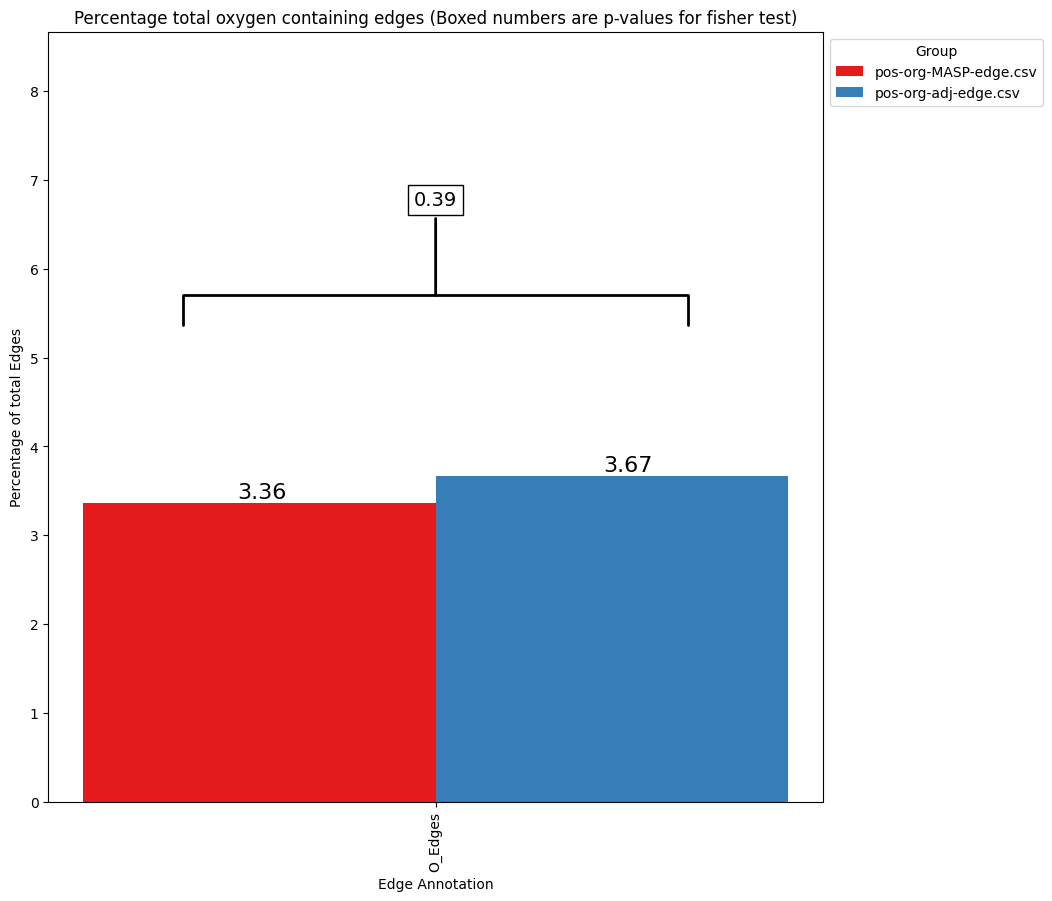

[3.6683107274969173]
[3.3646069233257845]
         Count
O_Edges    238
[0.3858073775966693]


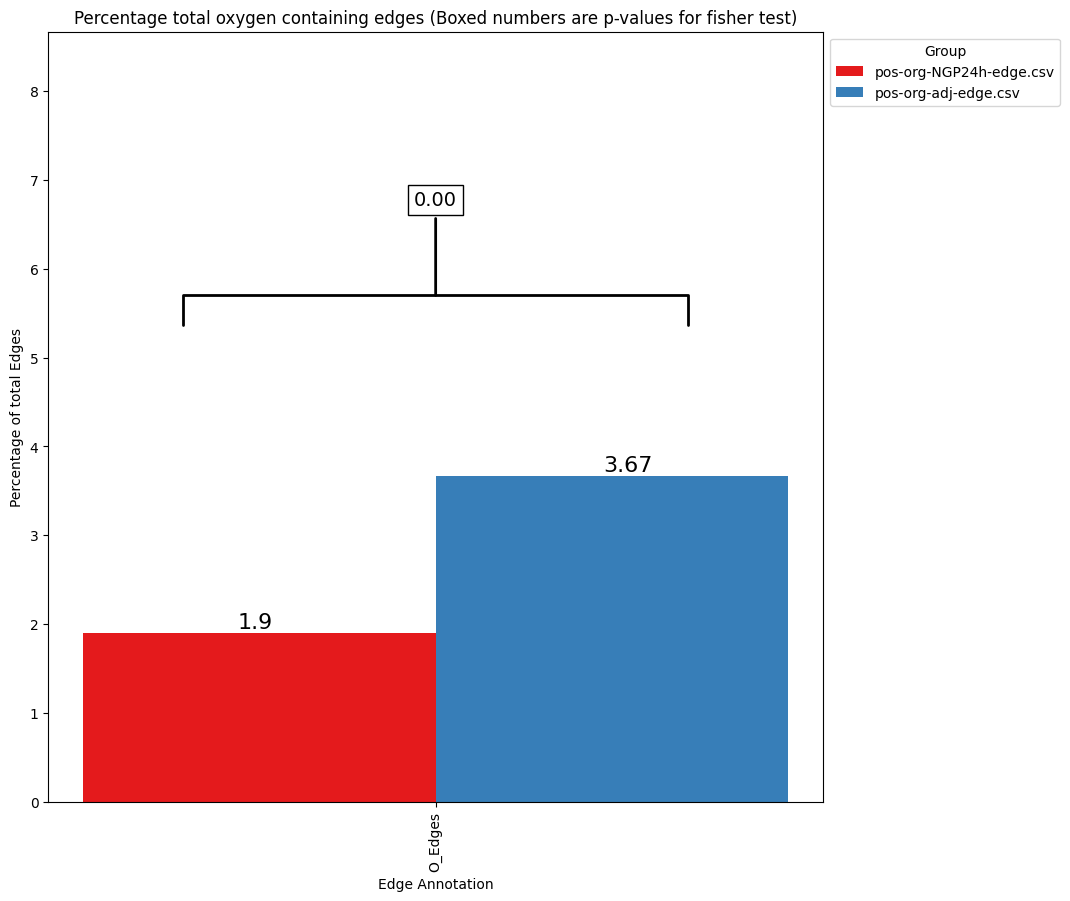

[3.6683107274969173]
[1.9049915601639738]
         Count
O_Edges    238
[2.1775881517365915e-07]


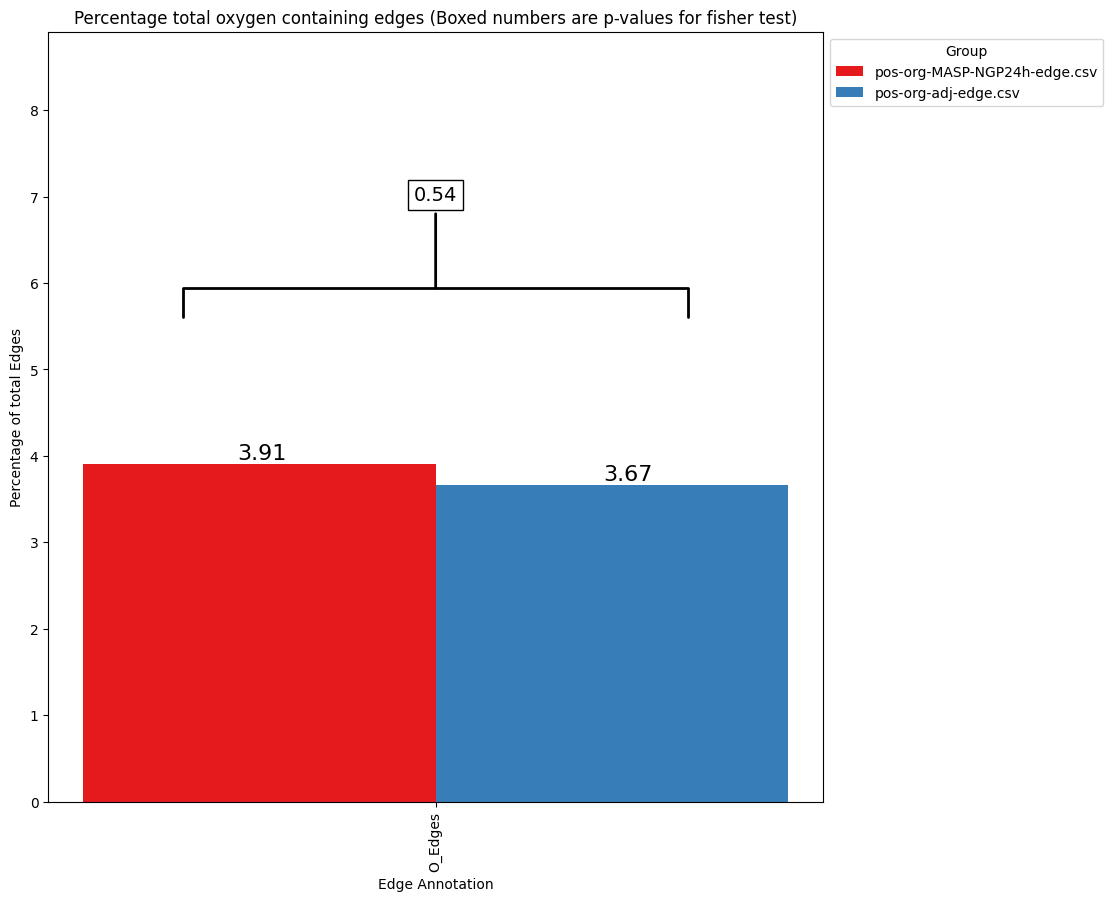

[3.6683107274969173]
[3.90625]
         Count
O_Edges    238
[0.5350947402267859]


In [2]:
counter = 0
for file in list_of_files:

    #read the files from the list
    control_df = pd.read_csv(file[0])
    experimental_df = pd.read_csv(file[1])
    
    #set empty cells with no annotations to NAN
    control_df['EdgeAnnotation'].replace('', np.nan, inplace=True)
    experimental_df['EdgeAnnotation'].replace('', np.nan, inplace=True)

    #filter out selfloops
    control_noSelfLoop = control_df.loc[(control_df["property1"]!=1)]
    experimental_noSelfLoop = experimental_df.loc[(experimental_df["property1"]!=1)]

    #filter out those with no annotation
    control_annotation_only = control_df.dropna(subset=['EdgeAnnotation'])
    experimental_annotation_only = experimental_df.dropna(subset=['EdgeAnnotation'])
    
    #make a list of all the annotations, then make a list of the unique annotations, and make an empty dictionary
    Control_Edge_Annotations_all =list(control_annotation_only.EdgeAnnotation)
    Control_Edge_Annotations_unique = list(control_annotation_only.EdgeAnnotation.unique())
    Control_Annotation_dict = {}

    #do it again for your other condition
    Experimental_Edge_Annotations_all =list(experimental_annotation_only.EdgeAnnotation)
    Experimental_Edge_Annotations_unique = list(experimental_annotation_only.EdgeAnnotation.unique())
    Experimental_Annotation_dict = {}
    
    #fill the dictionary with the annotation name and then how many times it is present in the set
    for item in Control_Edge_Annotations_unique:
        Control_Annotation_dict[item] = Control_Edge_Annotations_all.count(item)
        
    #do it again for the other condition
    for item in Experimental_Edge_Annotations_unique:
        Experimental_Annotation_dict[item] = Experimental_Edge_Annotations_all.count(item)
    
    #sort the dictionaries
    sorted_df_Control = sort_dictionary_by_value(Control_Annotation_dict)
    sorted_df_Experimental = sort_dictionary_by_value(Experimental_Annotation_dict)
    
    #make a dataframe with the annotations and counts and then export it to a csv for reference later
    df_Control = pd.DataFrame.from_dict(sorted_df_Control, orient='index') 
    df_Control.columns = ['Count']
    df_Control.to_csv ("Annotations_Control" + list_of_comparisons[counter] + '.csv')   
    
    #do it again for other condition
    df_Experimental = pd.DataFrame.from_dict(sorted_df_Experimental, orient='index') 
    df_Experimental.columns = ['Count']
    df_Experimental.to_csv ("Annotations_Experimental_" + list_of_comparisons[counter] + '.csv')
    
##################################
###        Graph Section       ###
##################################

    
#the following chunk will subset your dataframes to only the top N metabolites that are in both datasets.
#It will skip over any non-shared metabolites
#To change the number of metabolites, edith 'if experimenetal_final_df.size ==' to be the number of metabolites

    experimental_final_df = pd.DataFrame({0}, index = ["O_Edges"], columns = ['Count'])
    control_final_df = pd.DataFrame({0}, index = ["O_Edges"], columns = ['Count'])

    for annotation in list(df_Experimental.index.values):
        if contains_O(annotation):
            experimental_final_df.iloc[0] = experimental_final_df.iloc[0] + df_Experimental.iloc[list(df_Experimental.index.values).index(annotation),0]
        else:
            pass

    for annotation in list(df_Control.index.values):
        if contains_O(annotation):
            control_final_df.iloc[0] = control_final_df.iloc[0] + df_Control.iloc[list(df_Control.index.values).index(annotation),0]
        else:
            pass
        
    #fill the dictionary with the annotation name and then how many times it is present in the set
    for item in Control_Edge_Annotations_unique:
        Control_Annotation_dict["O_Edges"] = control_final_df.iloc[0]
        
    #do it again for the other condition
    for item in Experimental_Edge_Annotations_unique:
        Experimental_Annotation_dict["O_Edges"] = experimental_final_df.iloc[0]   
        
        
    top_N = list(experimental_final_df.index.values)

    #set locations on x axis
    X_axis = np.arange(len(top_N))

#create bars for the graph
    #create experimental bars
    Experimental_bars = experimental_final_df['Count']
    
    #create control bars
    Control_bars = control_final_df['Count']

#Determine values for graphing and for fisher calculations
    #find edge total for Control and Experimental
    Control_total_edge = len(control_noSelfLoop.index)
    Experimental_total_edge = len(experimental_noSelfLoop.index)

    #create percentages for edges
    Control_percents = [(i/Control_total_edge)*100 for i in Control_bars]
    Experimental_percents = [(i/Experimental_total_edge)*100 for i in Experimental_bars]
    
    #determine the fisher values
    df_Control_fisher = pd.DataFrame()
    for item in top_N:
        fisher_counts_control = []
        fisher_counts_control.append(Control_Annotation_dict[item])
        Other = (Control_total_edge - Control_Annotation_dict[item])
        fisher_counts_control.append(Other)
        df_Control_fisher[item] = fisher_counts_control
        df_Control_fisher = df_Control_fisher.copy() #This is to defragment the dataframe. There is probably an easier way

    
    df_Experimental_fisher = pd.DataFrame()
    for item in top_N:
        fisher_counts_experimental = []
        fisher_counts_experimental.append(Experimental_Annotation_dict[item])
        Other = Experimental_total_edge - Experimental_Annotation_dict[item]
        fisher_counts_experimental.append(Other)
        df_Experimental_fisher[item] = fisher_counts_experimental
        df_Experimental_fisher = df_Experimental_fisher.copy() #This is to defragment the dataframe. There is probably an easier way
    
    fisher_values = []
    
    fisher_values.append(stats.fisher_exact([[Control_bars[0],Control_total_edge],
                            [Experimental_bars[0],Experimental_total_edge]])[1])
    
    fisher_values[0]

#Graph parameters
    #set bar width and colors
    barWidth = 0.4
    colors = sns.color_palette("Set1", n_colors=2)
    #set figure size
    fig,ax=plt.subplots(figsize=(10,10))

    #plot bars, the + and - value just off set the bars for the don't overlap but are side by side
    plt.bar(X_axis + 0.2, Control_percents, color=colors[1], width=barWidth, label=file[0])
    plt.bar(X_axis - 0.2, Experimental_percents, color=colors[0], width=barWidth, label=file[1])

    #customize axis
    plt.xticks(X_axis, top_N)
    plt.xlabel("Edge Annotation")
    plt.xticks(rotation=90)
    plt.ylabel("Percentage of total Edges")
    plt.ylim((0,max(max(Experimental_percents) + 5 ,max(Control_percents) + 5)))

    #adjust the widthB parameter based on the number of bars. Adjust bar labels. Works for up to 10
    widthB = ['13.0', '6', '3.5', '3', '2.5', '2', '1.5', '1.25', '1.0', '1.0']
    textXControl = [0.19, 0.17, 0.15, 0.13, 0.11, 0.09, 0.07, 0.05, 0.03, 0.01]
    textXExperiment = [0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.40, 0.425, 0.45]
    
    #add values to top of bars
        
    Control_rounded = [round(i, 2) for i in Control_percents]
    for i, v in enumerate(Control_rounded):
        plt.text(X_axis[i] + textXControl[len(top_N) - 1], v + 0.05, str(v), fontsize = 16)
        #adds fisher value. Only need this once. Either loops works, but I chose this one
        #NOTE: you might need to address "widthB at the bottom based on your boxplot width"
        ax.annotate("{:.2f}".format(fisher_values[i]), xy=(X_axis[i], max((Experimental_percents[i] + 2), (Control_percents[i] + 2))), 
                    xytext=(X_axis[i], max((Experimental_percents[i] + 3), (Control_percents[i] + 3))), xycoords='data', 
                    fontsize=14, ha='center', va='bottom', bbox=dict(boxstyle='square', fc='white', color='k'),
                    arrowprops=dict(arrowstyle='-[, widthB=' + widthB[len(top_N) - 1] + ', lengthB=1.5', lw=2.0, color='k'))

    Experimental_rounded = [round(i, 2) for i in Experimental_percents]
    for i, v in enumerate(Experimental_rounded):
        plt.text(X_axis[i] - textXExperiment[len(top_N) - 1], v + 0.05, str(v), fontsize = 16)

    # Add a legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title='Group', loc='upper left', bbox_to_anchor=(1,1), ncol=1)
    
    plt.title('Percentage total oxygen containing edges (Boxed numbers are p-values for fisher test)')
    
    # save plot before show because plt.show() will create a new plot.
    # I also add some new key word to make your output plot high resolution and show all content without cut
    plt.savefig("EdgeAnnotations_OnlyOxygen_comparison"+list_of_comparisons[counter]+'.pdf',dpi=300, bbox_inches='tight')

    # Show graphic
    plt.show()
    
    counter += 1
    print(Control_percents)
    print(Experimental_percents)
    print(control_final_df)
    print(fisher_values)

In [3]:
control_df

,component,cosine_score,EdgeAnnotation,EdgeScore,EdgeType,explained_intensity,interaction,mass_difference,name,node1,node2,property1,selected,shared interaction,shared name
0,-1,0.9917,NaN,0.9917,Cosine,6.0,-,-0.001,984 (-) 6,6,984,6.0,False,-,984 (-) 6
1,-1,0.9931,NaN,0.9931,Cosine,982.0,-,0.000,984 (-) 982,982,984,982.0,False,-,984 (-) 982
2,-1,0.9700,NaN,0.9700,Cosine,894.0,-,0.003,3734 (-) 894,894,3734,894.0,False,-,3734 (-) 894
3,-1,0.9700,NaN,0.9700,Cosine,424.0,-,0.006,3734 (-) 424,424,3734,424.0,False,-,3734 (-) 424
4,-1,0.9825,NaN,0.9825,Cosine,1072.0,-,0.008,3734 (-) 1072,1072,3734,1072.0,False,-,3734 (-) 1072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7226,-1,0.9903,C2H4,0.9903,Cosine,3342.0,-,-28.032,3772 (-) 3342,3342,3772,3342.0,False,-,3772 (-) 3342
7227,-1,0.7244,NaN,0.7244,Cosine,163.0,-,-269.309,3772 (-) 163,163,3772,163.0,False,-,3772 (-) 163
7228,-1,0.7561,NaN,0.7561,Cosine,3164.0,-,-271.324,3772 (-) 3164,3164,3772,3164.0,False,-,3772 (-) 3164
7229,-1,0.9925,NaN,0.9925,Cosine,980.0,-,-0.001,984 (-) 980,980,984,980.0,False,-,984 (-) 980


In [4]:
experimental_df

,component,cosine_score,EdgeAnnotation,EdgeScore,EdgeType,explained_intensity,interaction,mass_difference,name,node1,node2,property1,selected,shared interaction,shared name
0,-1,0.9917,NaN,0.9917,Cosine,6.0,-,-0.001,984 (-) 6,6,984,6.0,False,-,984 (-) 6
1,-1,0.9931,NaN,0.9931,Cosine,982.0,-,0.000,984 (-) 982,982,984,982.0,False,-,984 (-) 982
2,-1,0.7227,NaN,0.7227,Cosine,170.0,-,-10.020,170 (-) 2151,170,2151,170.0,False,-,170 (-) 2151
3,-1,0.9396,C2H4,0.9396,Cosine,32.0,-,28.031,170 (-) 32,32,170,32.0,False,-,170 (-) 32
4,-1,0.9364,C3H6,0.9364,Cosine,76.0,-,42.047,170 (-) 76,76,170,76.0,False,-,170 (-) 76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6355,-1,1.0000,NaN,1.0000,Cosine,1.0,-,0.000,325 (-) 325,325,325,1.0,False,-,325 (-) 325
6356,-1,0.9789,NaN,0.9789,Cosine,62.0,-,-0.000,3290 (-) 62,62,3290,62.0,False,-,3290 (-) 62
6357,-1,0.8578,NaN,0.8578,Cosine,2527.0,-,-0.000,3290 (-) 2527,2527,3290,2527.0,False,-,3290 (-) 2527
6358,-1,0.9925,NaN,0.9925,Cosine,980.0,-,-0.001,984 (-) 980,980,984,980.0,False,-,984 (-) 980
